**Import Library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



**Scrape data harga emas**

In [2]:
import requests
import pandas as pd

# Scrape data dengan API
response = requests.get("https://pluang.com/api/asset/gold/pricing?daysLimit=20000")
coba = response.json()

# manipulasi data dan transformasi periode data
hargaemas = pd.DataFrame(coba['data']['history'])
hargaemas['tgl'] = pd.to_datetime(hargaemas['updated_at'].str[:10], format="%Y-%m-%d")
hargaemas = hargaemas.iloc[:, [1, 2, 3, 5]]

hargaemas.to_csv('hargaemas.csv', index=False)

# sekilas data
hargaemas.head()

,sell,buy,installment,tgl
0,1840675,1794658,1840675,2025-05-21
1,1817679,1772237,1817679,2025-05-20
2,1840319,1794311,1840319,2025-05-19
3,1836592,1790677,1836592,2025-05-18
4,1836592,1790677,1836592,2025-05-17


**Praproses Data**


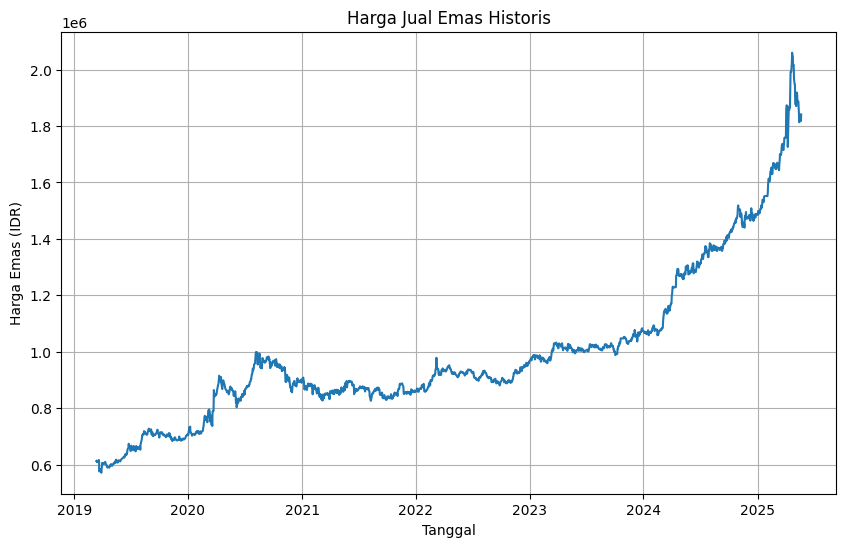

In [3]:
# Membaca file CSV
file_path = 'hargaemas.csv'
data = pd.read_csv(file_path)

# Mengonversi kolom 'tgl' menjadi tipe data datetime dan menjadikannya sebagai indeks
data['tgl'] = pd.to_datetime(data['tgl'])
data.set_index('tgl', inplace=True)

# Pilih harga jual (atau beli) untuk forecasting
price_data = data['sell']  #  bisa mengganti 'sell' dengan 'buy' jika ingin memprediksi harga beli

# Visualisasi data harga jual emas
plt.figure(figsize=(10, 6))
plt.plot(price_data)
plt.title('Harga Jual Emas Historis')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()

**Membangun Model ARIMA untuk Time Series Forecasting**

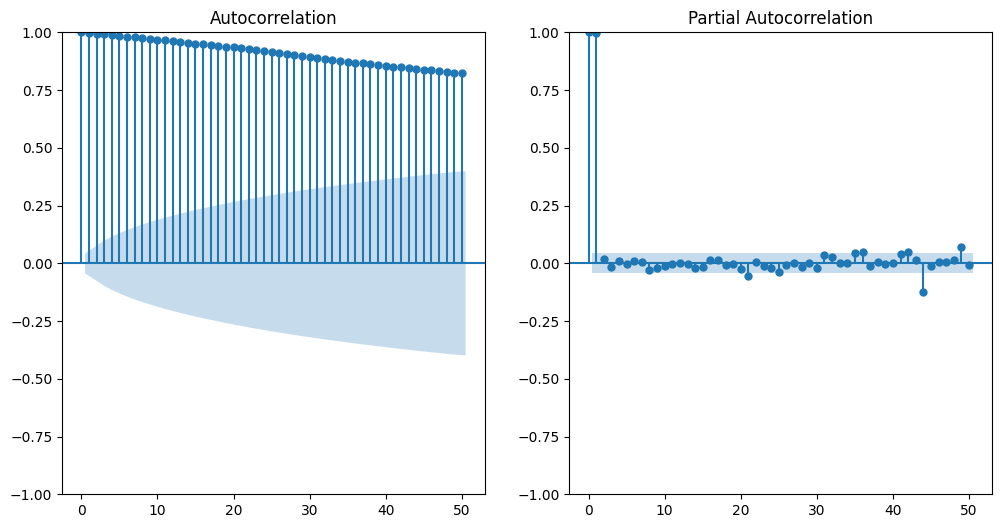

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(price_data, lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(price_data, lags=50, ax=plt.gca())
plt.show()


**Membangun Model ARIMA**

In [5]:
# Gabungkan data dengan tanggal duplikat (ambil rata-rata atau nilai terakhir)
price_data = price_data.groupby(price_data.index).last()

# Pastikan index urut dan set frekuensi harian
price_data = price_data.sort_index()
price_data = price_data.asfreq('D')

# Membangun model ARIMA
model = ARIMA(price_data, order=(5, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   sell   No. Observations:                 2261
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -20711.485
Date:                Wed, 21 May 2025   AIC                          41434.970
Time:                        14:39:06   BIC                          41469.308
Sample:                    03-14-2019   HQIC                         41447.500
                         - 05-21-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0140      0.012     -1.212      0.225      -0.037       0.009
ar.L2         -0.0141      0.009     -1.627      0.104      -0.031       0.003
ar.L3         -0.0141      0.010     -1.352      0.1

**Prediksi Harga Emas di Masa Depan**

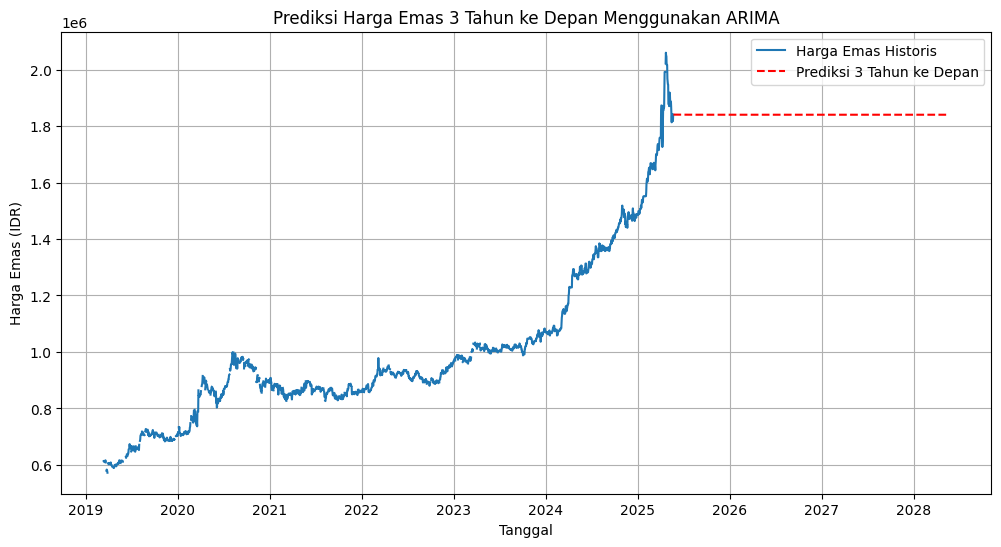

In [6]:
# Prediksi harga emas untuk 3 tahun ke depan (1095 hari)
forecast_3y = model_fit.forecast(steps=1095)

# Buat indeks tanggal untuk hasil prediksi (dimulai setelah tanggal terakhir data historis)
last_date = price_data.index[-1]  # Mendapatkan tanggal terakhir data historis
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=1095, freq='D')

# Visualisasi hasil prediksi 3 tahun ke depan dengan garis merah bergelombang (dashed)
plt.figure(figsize=(12, 6))
plt.plot(price_data, label='Harga Emas Historis')
plt.plot(future_dates, forecast_3y, label='Prediksi 3 Tahun ke Depan', color='red', linestyle='--')
plt.legend()
plt.title('Prediksi Harga Emas 3 Tahun ke Depan Menggunakan ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()


**Evaluasi Model**

In [8]:
aligned_true, aligned_pred = price_data.align(model_fit.fittedvalues, join='inner')
mask = (~aligned_true.isna()) & (~aligned_pred.isna())
mae = mean_absolute_error(aligned_true[mask], aligned_pred[mask])
rmse = np.sqrt(mean_squared_error(aligned_true[mask], aligned_pred[mask]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 5676.94
RMSE: 16831.91


**Penyempurnaan Model Dengan Sarima**

                                      SARIMAX Results                                       
Dep. Variable:                                 sell   No. Observations:                 2261
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood              -20998.935
Date:                              Wed, 21 May 2025   AIC                          42013.870
Time:                                      14:39:45   BIC                          42059.613
Sample:                                  03-14-2019   HQIC                         42030.567
                                       - 05-21-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0354      0.014     -2.505      0.012      -0.063      -0.008
ar.L2         -0.03

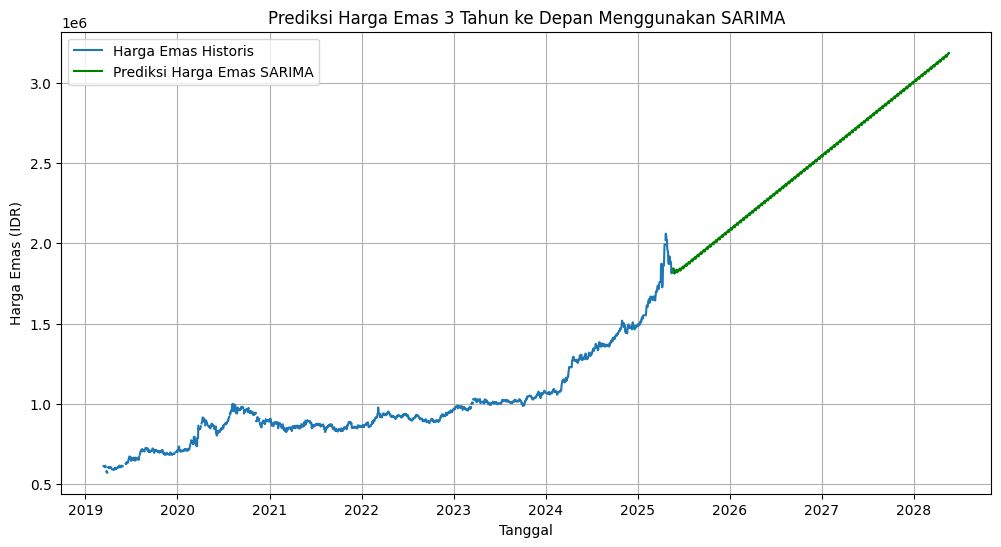

MAE SARIMA: 7387.20
RMSE SARIMA: 20611.11


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Membangun model SARIMA dengan penyesuaian untuk komponen musiman dan AR
sarima_model = SARIMAX(price_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Menambahkan MA pada musim (1, 1, 1, 12)
sarima_model_fit = sarima_model.fit()

# Ringkasan model SARIMA
print(sarima_model_fit.summary())

# Memprediksi harga emas dengan SARIMA untuk 3 tahun ke depan (1095 hari)
sarima_forecast = sarima_model_fit.forecast(steps=1095)

# Buat indeks tanggal untuk hasil prediksi dimulai setelah data terakhir
last_date = price_data.index[-1]  # Mendapatkan tanggal terakhir data historis
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=1095, freq='D')

# Visualisasi hasil prediksi SARIMA untuk 3 tahun ke depan
plt.figure(figsize=(12, 6))
plt.plot(price_data, label='Harga Emas Historis')
plt.plot(future_dates, sarima_forecast, label='Prediksi Harga Emas SARIMA', color='green')
plt.legend()
plt.title('Prediksi Harga Emas 3 Tahun ke Depan Menggunakan SARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()

# Untuk evaluasi, prediksi in-sample SARIMA
sarima_in_sample_pred = sarima_model_fit.fittedvalues

# Align dengan data asli
aligned_true_sarima, aligned_pred_sarima = price_data.align(sarima_in_sample_pred, join='inner')
mask_sarima = (~aligned_true_sarima.isna()) & (~aligned_pred_sarima.isna())

mae_sarima = mean_absolute_error(aligned_true_sarima[mask_sarima], aligned_pred_sarima[mask_sarima])
rmse_sarima = np.sqrt(mean_squared_error(aligned_true_sarima[mask_sarima], aligned_pred_sarima[mask_sarima]))

print(f"MAE SARIMA: {mae_sarima:.2f}")
print(f"RMSE SARIMA: {rmse_sarima:.2f}")
